In [4]:
import numpy as np
import scipy.fft as fft
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
from functools import partial

"""
read data from raw filamentJ plugin output.
main problem is that each frame does not have an equal number of points, but this is fixed later.
"""
def read_tracking_data(file_path):

    frames = {}
    with open(file_path, 'r') as f:
        for line in f:
            if len(line.strip().split('\t')) == 5:
                parts = line.strip().split('\t')
                frame_id = int(parts[0])
                point_id = int(parts[1])
                x = float(parts[2])
                y = float(parts[3])

                if frame_id not in frames:
                    frames[frame_id] = []
                frames[frame_id].append((x, y))

    #delete frames with less than 7 coordinates, spline cannot fit these
    frames = {frame_id:frame for frame_id,frame in frames.items() if len(frame) > 6}



    return frames

"""
load in tracking data from other tracking .txt format (neither the current imageJ plugin nor my python code)
this data was probably preprocessed, and usually has names like txt1_27beads.txt
"""
def parse_tracking_data_old(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    coordinates = []

    for i in range(0, len(lines), 2):
        x_coords = list(map(float, lines[i].split()[1:]))
        y_coords = list(map(float, lines[i + 1].split()[1:]))
        coords = np.array(list(zip(x_coords, y_coords)))
        coordinates.append(coords)

    return np.array(coordinates)

"""
find distance array, that is, convert (x,y) -> L2 distance from mean
"""
def distances(coords):
    frames = coords.shape[0]

    #this is a (Nx2) matrix, N = number of points used to track, representing mean positions
    means = np.mean(coords,axis=0)

    #distance array
    dists = coords-np.array(np.array(frames*[means]))
    dists = np.linalg.norm(coords, 2, axis=2)

    return dists

"""
Calculate FFT, then F(q), then omega(q) of distances.
"""
def distances_to_phonons(dists, k_b = 1.38e-23, T = 298, m = 1e-10):
    fft_dists = fft.fft(dists,axis=1)
    variances = np.var(fft_dists,axis=0)
    F = 2*k_b*T/variances
    omegas = np.sqrt(F/m)

    #convert from interval [0,2pi] to [-pi,pi]
    omegas = np.concatenate((np.array_split(omegas,2)[1],np.array_split(omegas,2)[0]))

    return omegas

"""
takes in dict of frames -> coordinates per frame, with the number of points perhaps varying across per frame.
fits splines, then returns np.array with equally spaced, constant number of points.
used for raw filamentJ data.
"""
def fit_spline_equally_spaced(coordinates, num_points=50):

    x = np.array([coord[0] for coord in coordinates])
    y = np.array([coord[1] for coord in coordinates])

    # Fit the parametric spline
    tck, u = splprep([x, y], s=0)

    # Evaluate the first derivative to approximate arc length
    x_der, y_der = splev(u, tck, der=1)
    ds = np.sqrt(x_der**2 + y_der**2)
    s = np.cumsum(ds)
    s = np.insert(s, 0, 0)  # Insert the starting point for cumulative sum
    s = np.delete(s,0)

    s_uniform = np.linspace(0, s[-1], num_points+2)
    s_uniform = np.delete(s_uniform,(0,1))

    u_uniform = np.interp(s_uniform, s, u)
    x_new, y_new = splev(u_uniform, tck)

    coordinates_array = np.transpose(np.array([x_new, y_new]))
    return coordinates_array


"""
Main function for all of this.
raw_coordinates just says if the data being loaded in is filamentJ raw output, true by default.
file_path is the full path to the file. If on windows, makesure all backslashes are replaced by forward slashes.
"""
def get_phonon_spectrum(file_path, num_points, raw_coordinates = True, dimer_mass = None):

    #some mass calculations, courtesy of emil
    #need to do this microtubule by microtubule, I haven't really examined this yet so I'm just taking his word on it
    if dimer_mass is None:
        dimer_MW = 110;  #kilograms/mol
        dimer_mass = dimer_MW/(6.022e23); #kilograms/molecule
        digital_to_meters_conversion = ((1*10^-6)/15.3)

    if raw_coordinates is True:
        #raw filamentJ data

        #load in data
        frames = read_tracking_data(file_path)
        frames = list(frames.values())

        #partially evaluate function to tell it number of points
        fit_spline_equally_spaced_partial = partial(fit_spline_equally_spaced,num_points=num_points)

        #spline-fit and then segment into needed number of segements
        equally_spaced_data = list(map(fit_spline_equally_spaced_partial,frames))
        equally_spaced_data = np.array(equally_spaced_data)

        #calculate distances, then omega(q)
        dists = digital_to_meters_conversion*distances(equally_spaced_data)
        omegas = distances_to_phonons(dists,m=dimer_mass)

    else:

        #load in data
        frames = parse_tracking_data_old(file_path)

        #calculate distances, then omega(q)
        dists = distances(frames)
        omegas = distances_to_phonons(dists)

    return omegas



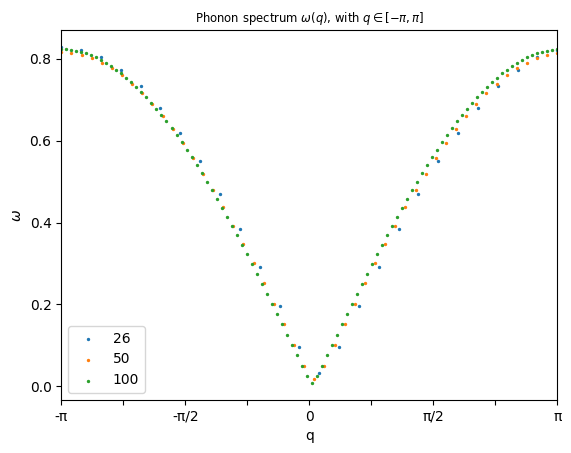

In [5]:
#this is the one used, file path to filamentJ tracking data
#enter file path here!
file_path_1 = '/home/yuming/Downloads/MT_1/50_per_Hyl_10ms_1000frames_5_MMStack.ome_MT1_cropped-snakes'

#enter dimer mass here when ready, it will still work when dimer is None.
dimer_mass = None

#range for q
lower, upper = -np.pi, np.pi

#scatter for each number of points, change number of points by changing num_points and label.
omegas1 = get_phonon_spectrum(file_path=file_path_1, num_points=26, dimer_mass=dimer_mass)
plt.scatter(np.linspace(lower, upper,num=len(omegas1)),omegas1, s=2, label = '26')

omegas2 = get_phonon_spectrum(file_path=file_path_1, num_points=50,dimer_mass=dimer_mass)
plt.scatter(np.linspace(lower, upper,num=len(omegas2)),omegas2, s=2, label = '50')

omegas3 = get_phonon_spectrum(file_path=file_path_1, num_points=100,dimer_mass=dimer_mass)
plt.scatter(np.linspace(lower, upper,num=len(omegas3)),omegas3, s=2, label = '100')

#set tickmarks
plt.rcParams['axes.xmargin'] = 0
plt.xticks(np.linspace(lower, upper,num=9,endpoint=True),['-π','','-π/2','','0','','π/2','','π'])

#plot!
plt.title(r'Phonon spectrum $\omega(q)$, with $q \in [-\pi,\pi]$', fontsize='small')
plt.xlabel('q')
plt.ylabel('$\omega$')


plt.legend(loc=3)
plt.show()